# 文本旋转校正

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [83]:
src = cv2.imread('../datas/text_rd30.jpg')
rgb = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

## 1.执行傅立叶变换

In [84]:
f = np.fft.fft2(gray.astype(np.float32))
fshift = np.fft.fftshift(f)
#取绝对值：将复数变化成实数
#取对数的目的为了将数据变化到较小的范围（比如0-255）
s1 = np.log(np.abs(f))
s2 = np.log(np.abs(fshift))

Text(0.5,1,'频域中心移动')

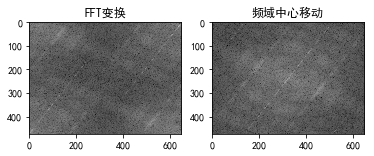

In [85]:
plt.subplot(121)
plt.imshow(s1,'gray')
plt.title('FFT变换')
plt.subplot(122)
plt.imshow(s2,'gray')
plt.title('频域中心移动')

In [86]:
print(s2)

[[8.42885803 7.18144345 7.61890326 ... 7.61890326 7.18144345 8.42885803]
 [7.99322453 8.2052249  7.22740499 ... 6.92841491 8.2012731  7.54970767]
 [8.26338451 7.30354199 8.11396999 ... 7.75651067 7.4878709  7.49151903]
 ...
 [8.05731544 7.58890818 8.1347115  ... 7.09983999 7.73463912 8.15462923]
 [7.49151903 7.4878709  7.75651067 ... 8.11396999 7.30354199 8.26338451]
 [7.54970767 8.2012731  6.92841491 ... 7.22740499 8.2052249  7.99322453]]


## 2.倾斜角检测

### 2.1直线检测

In [87]:
_,binary = cv2.threshold(s2,140,255,cv2.THRESH_BINARY)

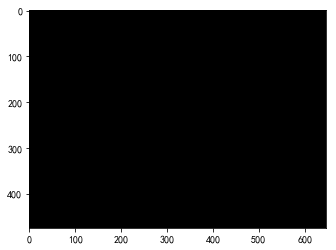

In [88]:
plt.imshow(binary,'gray')

In [111]:
s2 = s2.astype(np.uint8)
lines = cv2.HoughLines(s2,1,np.pi/180,180)
print(lines.shape)

(7607, 1, 2)


In [119]:
s2_rgb = cv2.cvtColor(s2,cv2.COLOR_GRAY2RGB)
for i in range(3):
    line = lines[i]
    rho = line[0,0]
    theta = line[0,1]
    # 变换成直线表达式
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = rho * a
    y0 = rho * b
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*a)
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*a)
    cv2.line(s2_rgb,(x1,y1),(x2,y2),(255,0,0),2)

Text(0.5,1,'检测到的直线')

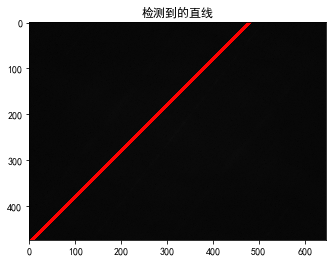

In [113]:
plt.imshow(s2_rgb)
plt.title('检测到的直线')

### 2.2计算旋转角度

In [130]:
theta_ll = 0
for i in range(10):
    line = lines[i]
    rho = line[0,0]
    the = line[0,1]
    angle = the * 180 / np.pi
    if angle > 0 and angle < 90:
        theta_ll = angle
        break
print('Rotation Angle:',theta_ll)

Rotation Angle: 45.00000125223908


In [132]:
# 角度转换
rows,cols = gray.shape
nrows,ncols = cv2.getOptimalDFTSize(rows),cv2.getOptimalDFTSize(cols)
print(rows,cols,nrows,ncols)
angleT = nrows * np.tan(theta_ll / 180 * np.pi) / ncols
theta = np.arctan(angleT) * 180 / np.pi
print('theat = ',theta)

474 647 480 648
theat =  36.52885656487553


## 3.仿射变换校正

In [133]:
center = (cols // 2,rows // 2)
scale = 1.0
warp_mat = cv2.getRotationMatrix2D(center,theta,scale)
dst = cv2.warpAffine(gray,warp_mat,(rows,cols),borderValue=(255,255,255))

Text(0.5,1,'校正结果')

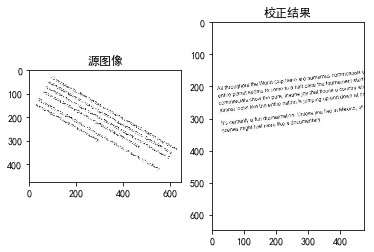

In [134]:
plt.subplot(121)
plt.imshow(gray,'gray')
plt.title('源图像')
plt.subplot(122)
plt.imshow(dst,'gray')
plt.title('校正结果')